# 2. Scattering transform

Welcome to this tutorial on transforming seismic data into scattering
coefficients using a scattering network. After we have introduced the data of interest and the scattering network in the previous notebooks, we will now walk
through the process of extracting scattering coefficients
from continuous seismograms with our pre-defined scattering network.
The scattering coefficients have been proven useful for data exploration tasks with continuous seismograms.
We will load the scattering network and the continuous seismogram, chunk the data into smaller pieces and then apply the network.

Made in April 2023 by René Steinmann and Léonard Seydoux.

Updated in November 2023.

> **Note**: This notebook requires the installation of the matplotlib library, which is not included in the default installation of the scatseisnet library. To install it, please visit the [matplotlib website](https://matplotlib.org/stable/users/installing.html).

In [1]:
import pickle

import numpy as np
from matplotlib import dates as mdates
from matplotlib import pyplot as plt

from obspy import read

plt.rcParams["date.converter"] = "concise"
%config InlineBackend.figure_format = "svg"

## 2.0 Load scattering network and seismograms

First, we need to load the scattering network. We will use the network designed
in the previous tutorial. We will also load the data we introduced at the beginning, containing the tremor signals.

In [2]:
network = pickle.load(open("../example/scattering_network.pickle", "rb"))
stream = read("../example/scattering_stream.mseed")

### Chunck seismograms

We chunk the data into equal-length segments.
The length of the segment was already defined when we created the scattering network in the previous notebook (`segment_duration_seconds`).
Therefore, we extract that information for the loaded network.
We chunk the data with the `stream.slide` method. Note that for larger datasets, this should be adapted since this method is not optimal.

In [3]:
# Extract segment length (from any layer)
segment_duration_seconds = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration_seconds, segment_duration_seconds * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

## 2.1 Scattering transformation

After collecting the data segments and the scattering network, we can now caclulate the scattering coefficients. Here we also set what kind of pooling we want to use by setting the `reduce_type` keyword argument to maximum (`np.max`), median (`np.median`), or average pooling (`np.mean`). This cell might take some time.

In [4]:
scattering_coefficients = network.transform(segments, reduce_type=np.median)

### Observe result from a single channel

In the following example one can observe the first-order scattering coefficients.
The first-order scattering coefficients resemble a classical spectrogram, where we see an amplitude information in relation to time and frequency.
In our case, we clearly the signature of the tremor signals, starting around 10:00.

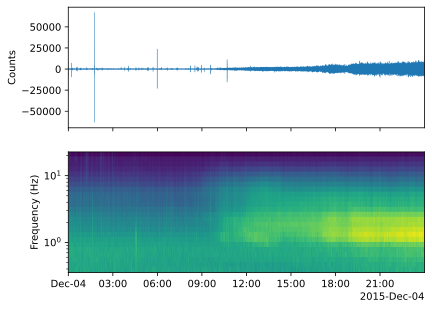

In [5]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies, order_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show()

### Save outputs for data exploration

Until now, we utilized the scatseisnet package to apply the scattering network to the three-component seismic data.
In the next tutorial, we use the scattering coefficients for data exlporation tasks such as dimensionality reduction and clustering.
Therefore, we save the first and second-order scattering coefficients as a npz-file.

In [6]:
np.savez(
    "../example/scattering_coefficients.npz",
    order_1=scattering_coefficients[0],
    order_2=scattering_coefficients[1],
    times=timestamps,
)